In [1]:
%matplotlib notebook
import xemc3
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors
import xarray as xr
import numpy as np
import ipywidgets as widgets
import mpl_interactions.ipyplot as iplt
from pathlib import Path
from brokenaxes import brokenaxes
from scipy.signal import argrelextrema
import scipy as sp

In [2]:
philip_folder =  "/u/phg/adas/atomdatpy/NetCDFs-new"
experiment_folder = "N03.00_P05.00_D05_R02.00-C"
plotfolder = "./plots"

In [3]:
ds = xr.open_dataset(f"{philip_folder}/{experiment_folder}.nc")

In [4]:
dsdir = Path("../atomdatpy/NetCDFs-new/")
# allfullds = dsdir.glob("*[!E][!z].nc")
# only_carbon_ds = allfullds.glob("*C.nc")
# only_carbon_ds = dsdir.glob("*-C.nc")
# dspaths = only_carbon_ds
useful_paths = []
for path in dsdir.glob("*.nc"):
    try:
        if path.stem[-1] == "C" or \
           path.stem.split("_")[3][0] == "C":
            useful_paths.append(path)
    except:
        ...
        #print("AAA", path)

# Radial Distribution

In [5]:
# outdated dsdir.glob("N03.00_P05.00_D0*.nc")
# in future: dsdir.glob("N03.00_P05.00_D02_R0*")
Prr, Qrr, Rrr = [], [], []
for i, path in enumerate(sorted(dsdir.glob("N03.00_P05.00_D02_R0*"), reverse=True)):
    print(f"{i}/{len(useful_paths)}", path)
    ds = xr.open_dataset(path)
    dsez = ds.Ez.sum(dim="Ionization")
    bean_outer_radius_map = ds.R_bounds[:,len(ds.theta)//2,0,:,0,0].mean(dim="delta_r")
    radial_ez_distribution = dsez.mean(dim=("theta", "phi"))
    Prr.append(bean_outer_radius_map)
    Qrr.append(radial_ez_distribution)
    Rrr.append(path)

0/175 ../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
1/175 ../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.00-C.nc
2/175 ../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc
3/175 ../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.00-C.nc
4/175 ../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
5/175 ../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc
6/175 ../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc


In [6]:
# sort paths
frads = [float(path.stem[20:24])/float(path.stem[9:13]) for path in Rrr]

In [7]:
fac_color = 1

shadows = np.array([
       0,     6,    31,   142,   256,   366,   524,   678,   822,
     937,  1055,  1161,  1277,  1385,  1483,  1588,  1700,  1813,
    1890,  1931,  1980,  2035,  2078,  2129,  2175,  2218,  2272,
    2321,  2371,  2429,  2492,  2567,  2643,  2743,  2839,  2920,
    2992,  3057,  3130,  3195,  3256,  3314,  3374,  3434,  3489,
    3541,  3592,  3661,  3722,  3776,  3842,  3897,  3968,  4022,
    4097,  4157,  4220,  4348,  4569,  4737,  4936,  5132,  5357,
    5584,  5738,  5883,  6018,  6219,  6386, 18432]) / 18432

shadows_r = np.array([6.238596, 6.239962, 6.241301, 6.242641, 6.243997, 6.245394, 6.246803,
       6.248227, 6.249666, 6.251124, 6.252602, 6.254102, 6.255627, 6.257178,
       6.258759, 6.260372, 6.262011, 6.263649, 6.265758, 6.265913, 6.266462,
       6.266985, 6.267488, 6.267976, 6.268452, 6.268922, 6.269391, 6.269861,
       6.270338, 6.270825, 6.271328, 6.271851, 6.2724  , 6.273082, 6.273707,
       6.274405, 6.275079, 6.275733, 6.276368, 6.276988, 6.277596, 6.278193,
       6.278781, 6.279364, 6.279943, 6.280519, 6.281096, 6.281674, 6.282257,
       6.282846, 6.283442, 6.28405 , 6.28467 , 6.285306, 6.285959, 6.286633,
       6.287316, 6.288021, 6.289876, 6.291572, 6.293187, 6.294802, 6.29651 ,
       6.298826, 6.300401, 6.302176, 6.303855, 6.305534, 6.307308, 6.309766, 6.51065])

In [8]:
def get_color(f, d):
    d2 = np.sqrt((10*d-2)/8)
    r = cm.magma( (f-0.4)*1.8 )
    s = tuple((1-d2)*rr + d2*0.6 for rr in r)
    #print(f,d,d2,r,s)
    return s

def get_color_diverging(v, ref, span):
    if v==ref:
        return (0.7,0.7,0.7)
    zero_one_frac = (v-ref)/span*2 + 0.5
    return cm.coolwarm( zero_one_frac )

In [9]:
plt.close("all")
fig = plt.figure(figsize=(6,3.62))
fig.tight_layout()
ax = brokenaxes(xlims=((5.87, 5.915), (6.135, shadows_r[-2]+0.005)), despine=False, fig=fig, wspace=6e-2, tilt=30)


MW_fac = 1e-6

for bean_outer_radius_map, radial_ez_distribution, path in zip(Prr[:-2],Qrr[:-2],Rrr[:-2]):
    #the normal ones
    ax.plot(bean_outer_radius_map, MW_fac * radial_ez_distribution, zorder=1,
            c=get_color(float(path.stem[20:24])/float(path.stem[9:13]), d=0.2),
           label= "$f_{\mathrm{rad}} =$" + str(float(path.stem[20:24])/float(path.stem[9:13])) +\
           ", $D=$0.2m$^2$/s")
    
    bean_outer_radius_map, radial_ez_distribution, path = Prr[0],Qrr[0],Rrr[0]
    
for bean_outer_radius_map, radial_ez_distribution, path in zip(Prr[:-3:-1],Qrr[:-3:-1],Rrr[:-3:-1]):
    ax.plot(bean_outer_radius_map, MW_fac * radial_ez_distribution, zorder=1,
            c=get_color(float(path.stem[20:24])/float(path.stem[9:13]), d=0.1*float(path.stem[-2:])),
           label= "$f_{\mathrm{rad}} =$" + str(float(path.stem[20:24])/float(path.stem[9:13])) +\
           ", $D=$" + str(float(path.stem[-2:])/10) + "m$^2$/s")

for i, s in enumerate(shadows):
    if i==len(shadows)-10:
        ax.axvspan(shadows_r[i], shadows_r[i+1],
                   facecolor=(*(0.0,)*3,min(fac_color*s, 1))) #, label="fraction of target cells")
    else:
        ax.axvspan(shadows_r[i], shadows_r[i+1],
                   facecolor=(*(0.0,)*3,min(fac_color*s, 1)))
ax.axvline(5.8807, c="k", zorder=1000, linestyle="-") #, label="magnetic axis") # core  
ax.text(5.8807, 1.2, "mag. axis", rotation=270, va="top", ha="left")
ax.axvline(6.2072, c="k", zorder=1000, linestyle="--") #, label="separatrix") # seperatrix
ax.text(6.2072, 1.2, "separatrix", rotation=270, va="top", ha="left")
ax.axvline(shadows_r[1], c="k", zorder=1000, linestyle=":") #, label="start of target shadow") # start of shadow
ax.text(shadows_r[1], 1.2, "target shadow", rotation=270, va="top", ha="left")
ax.text(6.303, 1.2, "end of simulation domain", rotation=90, va="top", ha="left")

    
ax.legend(loc=3)
ax.set_ylabel("Cell averaged emissivity [MW/m$^3$]")
ax.set_xlabel("Bean shape outer radius [m]", labelpad=20)
#fig.tight_layout()

fig.savefig(f"{plotfolder}/radial-emissivity-distribution.pdf")
fig.savefig(f"{plotfolder}/radial-emissivity-distribution.png", dpi=200)

<IPython.core.display.Javascript object>

In [10]:
# bean_outer_radius_map[47] # -> R[47] == SEPARATRIX
bean_outer_radius_map[1] - 6*(bean_outer_radius_map[1]-bean_outer_radius_map[0])

<xarray.DataArray 'R_bounds' ()>
array(5.85093745)
Coordinates:
    phi_bounds  float64 0.0

# toroidal changes in Ez

In [11]:
def crossec_pcolorgrid(ds, phi):
    # (A+1)*(B+1) = AB + A + B +1
    outR = np.empty((len(ds["r"])+1, len(ds["theta"])+1))
    outZ = outR.copy()
    
    outR[:-1,:-1] = ds["R_bounds"][ :, :,phi,0,0,0]  # AB
    outR[:-1, -1] = ds["R_bounds"][ :,-1,phi,0,1,0]  # A
    outR[ -1,:-1] = ds["R_bounds"][-1, :,phi,1,0,0]  # B
    outR[ -1, -1] = ds["R_bounds"][-1,-1,phi,1,1,0]  # 1
    
    outZ[:-1,:-1] = ds["z_bounds"][ :, :,phi,0,0,0]  # AB
    outZ[:-1, -1] = ds["z_bounds"][ :,-1,phi,0,1,0]  # A
    outZ[ -1,:-1] = ds["z_bounds"][-1, :,phi,1,0,0]  # B
    outZ[ -1, -1] = ds["z_bounds"][-1,-1,phi,1,1,0]  # 1
    
    return outR, outZ
    

In [12]:
frad_paths = (sorted(dsdir.glob("N03.00_P05.00_D02_R0*"), reverse=True))[:5]
all_paths = (sorted(dsdir.glob("N03.00_P05.00_D02_R0*"), reverse=True))[:]
diff_paths = [all_paths[-3], all_paths[-1], all_paths[-2]]
# frad_paths

In [13]:
frad_paths

[PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.00-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.00-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc')]

In [14]:
cpath = frad_paths[0]
ds = xr.open_dataset(cpath)
dsez = ds.Ez.sum(dim="Ionization", skipna=False)
(dsez.mean(dim=("theta", "phi"))).argmax()

<xarray.DataArray 'Ez' ()>
array(65)

<IPython.core.display.Javascript object>


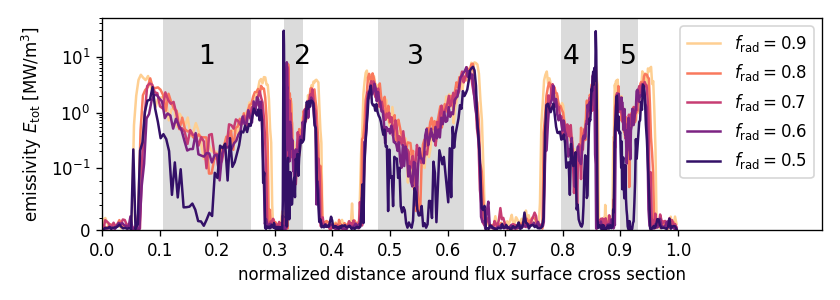

In [15]:
fig, ax = plt.subplots(figsize=(7,2.5))
MW_fac = 1e-6
for cpath in frad_paths:
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()

    # yin = dsez.mean(dim="phi").isel(r=55)
    ymax = dsez.mean(dim="phi").isel(r=max_ez_r)
    # yout = dsez.mean(dim="phi").isel(r=75)
    QRB_index = 13
    rz_coords = np.empty((2, len(ds.theta)+1))
    rz_coords[0, :-1] = ds.R_bounds.isel(r=max_ez_r)[:,QRB_index].mean(dim=("delta_r", "delta_theta", "delta_phi"))
    rz_coords[1, :-1] = ds.z_bounds.isel(r=max_ez_r)[:,QRB_index].mean(dim=("delta_r", "delta_theta", "delta_phi"))
    rz_coords[0, -1] = rz_coords[0, 0]
    rz_coords[1, -1] = rz_coords[1, 0]
    distance_along_mfs = np.array([0, *(np.diff(rz_coords, axis=1)**2).sum(axis=0).cumsum()])
    distance_along_mfs /= distance_along_mfs[-1]
    ax.plot(distance_along_mfs[:-1], MW_fac * ymax,
            c=get_color(float(cpath.stem[20:24])/float(cpath.stem[9:13]), d=0.2),
            label="$f_{\mathrm{rad}} =$" + str(float(cpath.stem[20:24])/float(cpath.stem[9:13])))
    #print(float(cpath.stem[20:24])/float(cpath.stem[9:13]), max_ez_r)

ax.set_yscale("symlog", linthresh=1e-1)
ax.set_ylim((0, 5e1))
ax.set_xlim((0,1.25))
ax.set_ylabel("emissivity $E_{\mathrm{tot}}$ [MW/m$^3$]")
ax.set_xlabel("normalized distance around flux surface cross section")
ax.legend(loc=1)
ax.set_xticks(np.linspace(0,1,11))
ax.set_yticks(np.hstack(( np.linspace(0,0.1,6), np.linspace(0.2,1,10), 
                          np.linspace(2,10,10), np.linspace(20,50,4) )), minor=True)
fig.tight_layout()

thts = [45, 155, 255, 365, 465]
for i, tht in enumerate(thts):
    ax.text(distance_along_mfs[tht], 10, 
                    f"{i+1}", size=16, zorder=1e4, c="k", ha="center", va="center")
    
    
target = np.load("./data/shadow_data_up_to_75.npy")[0]
target_alpha = np.clip(target < 100, 0, 1)/7
for i, conn_l_a in enumerate(target_alpha):
    ax.axvspan(distance_along_mfs[i], distance_along_mfs[i+1],
               facecolor=(*(0.0,)*3, conn_l_a ))
    
fig.savefig(f"{plotfolder}/poloidal-emissivity-distribution.pdf")
fig.savefig(f"{plotfolder}/poloidal-emissivity-distribution.png", dpi=200)
# Emissivity going poloidially along the magnetic flux surface at the respective maximum emissivity radius.
# plotted for D=0.2

<IPython.core.display.Javascript object>


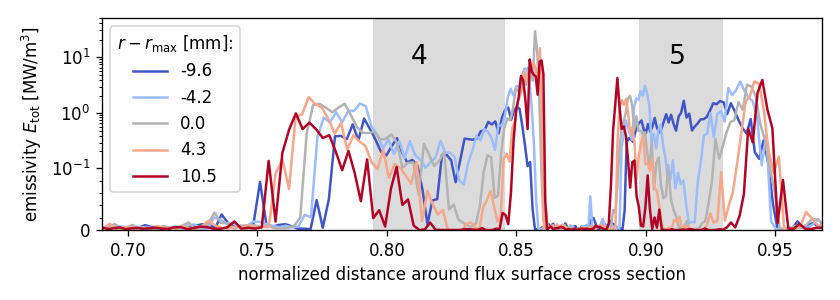

In [16]:
fig, ax = plt.subplots(figsize=(7,2.5))
MW_fac = 1e-6
cpath = all_paths[-3]
max_ez_r_0p9 = 65

ds = xr.open_dataset(cpath)
dsez = ds.Ez.sum(dim="Ionization", skipna=False)
max_ez_r_raw = (dsez.mean(dim=("theta", "phi"))).argmax()
bean_r = ds.R_bounds[:,256,0,:,0,0].mean(dim="delta_r")

for delta_ri in (np.linspace(-1,1,5)*7).astype(int):
    max_ez_r = max_ez_r_raw + delta_ri

    # yin = dsez.mean(dim="phi").isel(r=55)
    ymax = dsez.mean(dim="phi").isel(r=max_ez_r)
    # yout = dsez.mean(dim="phi").isel(r=75)
    QRB_index = 13
    rz_coords = np.empty((2, len(ds.theta)+1))
    rz_coords[0, :-1] = ds.R_bounds.isel(r=max_ez_r)[:,QRB_index].mean(dim=("delta_r", "delta_theta", "delta_phi"))
    rz_coords[1, :-1] = ds.z_bounds.isel(r=max_ez_r)[:,QRB_index].mean(dim=("delta_r", "delta_theta", "delta_phi"))
    rz_coords[0, -1] = rz_coords[0, 0]
    rz_coords[1, -1] = rz_coords[1, 0]
    distance_along_mfs = np.array([0, *(np.diff(rz_coords, axis=1)**2).sum(axis=0).cumsum()])
    distance_along_mfs /= distance_along_mfs[-1]
    
    # mm
    r_frac = 1000*(bean_r[max_ez_r] - bean_r[max_ez_r_raw]).data[tuple()]
    
    ax.plot(distance_along_mfs[:-1], MW_fac * ymax,
            c=get_color_diverging(bean_r[max_ez_r], bean_r[max_ez_r_raw], 0.04),
            label=f"{r_frac:.1f}")

ax.set_yscale("symlog", linthresh=1e-1)
ax.set_ylim((0, 5e1))
ax.set_xlim((0,1.25))
ax.set_ylabel("emissivity $E_{\mathrm{tot}}$ [MW/m$^3$]")
ax.set_xlabel("normalized distance around flux surface cross section")
ax.set_xticks(np.linspace(0,1,21))
ax.set_yticks(np.hstack(( np.linspace(0,0.1,6), np.linspace(0.2,1,10), 
                          np.linspace(2,10,10), np.linspace(20,50,4) )), minor=True)
fig.tight_layout()

thts = [45, 155, 255, 365, 465]
for i, tht in enumerate(thts):
    ax.text(distance_along_mfs[tht], 10, 
                    f"{i+1}", size=16, zorder=1e4, c="k", ha="center", va="center")
    
ax.legend(loc=2, title="$r-r_{\mathrm{max}}$ [mm]:")  # $f_{\mathrm{rad}} = 0.9,~D=0.2$m$^2$/s\n
ax.set_xlim((0.69, 0.968))

target = np.load("./data/shadow_data_up_to_75.npy")[0]
target_alpha = np.clip(target < 100, 0, 1)/7
for i, conn_l_a in enumerate(target_alpha):
    ax.axvspan(distance_along_mfs[i], distance_along_mfs[i+1],
               facecolor=(*(0.0,)*3, conn_l_a ))
    
fig.savefig(f"{plotfolder}/poloidal-emissivity-distribution-radius-variation.pdf")
fig.savefig(f"{plotfolder}/poloidal-emissivity-distribution-radius-variation.png", dpi=200)
# Emissivity going poloidially along the magnetic flux surface at the respective maximum emissivity radius.
# plotted for D=0.2, frad=0.5
# radii referenced are the ones radially in bean

<IPython.core.display.Javascript object>


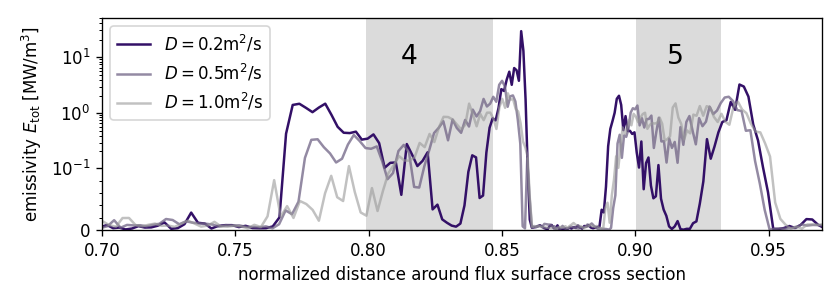

(0.198177, 0.063862, 0.404009, 1.0) 0.5 0.2
(0.4442423292285912, 0.39217813292907183, 0.5240284860444544, 0.7550510257216823) 0.5 0.5
(0.6, 0.6, 0.6, 0.6) 0.5 1.0


In [17]:
fig, ax = plt.subplots(figsize=(7,2.5))
MW_fac = 1e-6
QRB_index = 13

for cpath in diff_paths:
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()

    # yin = dsez.mean(dim="phi").isel(r=55)
    ymax = dsez.mean(dim="phi").isel(r=max_ez_r)
    # yout = dsez.mean(dim="phi").isel(r=75)
    QRB_index = 13
    rz_coords = np.empty((2, len(ds.theta)+1))
    rz_coords[0, :-1] = ds.R_bounds.isel(r=max_ez_r)[:,QRB_index].mean(dim=("delta_r", "delta_theta", "delta_phi"))
    rz_coords[1, :-1] = ds.z_bounds.isel(r=max_ez_r)[:,QRB_index].mean(dim=("delta_r", "delta_theta", "delta_phi"))
    rz_coords[0, -1] = rz_coords[0, 0]
    rz_coords[1, -1] = rz_coords[1, 0]
    distance_along_mfs = np.array([0, *(np.diff(rz_coords, axis=1)**2).sum(axis=0).cumsum()])
    distance_along_mfs /= distance_along_mfs[-1]
    fradval = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    ax.plot(distance_along_mfs[:-1], MW_fac * ymax,
            c=get_color(fradval, d=diffval),
            label="$D=$" + str(diffval) + "m$^2$/s") # $f_{\mathrm{rad}} =$" + str(fradval) + ", 
    print(get_color(fradval, d=diffval), fradval, diffval)

ax.set_yscale("symlog", linthresh=1e-1)
ax.set_ylim((0, 5e1))
ax.set_xlim((0,1.25))
ax.set_ylabel("emissivity $E_{\mathrm{tot}}$ [MW/m$^3$]")
ax.set_xlabel("normalized distance around flux surface cross section")
ax.legend(loc=2)
ax.set_xticks(np.linspace(0,1,21))
ax.set_yticks(np.hstack(( np.linspace(0,0.1,6), np.linspace(0.2,1,10), 
                          np.linspace(2,10,10), np.linspace(20,50,4) )), minor=True)
fig.tight_layout()

thts = [45, 155, 255, 365, 465]
for i, tht in enumerate(thts):
    ax.text(distance_along_mfs[tht], 10, 
                    f"{i+1}", size=16, zorder=1e4, c="k", ha="center", va="center")
ax.set_xlim((0.7, 0.97))

target = np.load("./data/shadow_data_up_to_75.npy")[0]
target_alpha = np.clip(target < 100, 0, 1)/7
for i, conn_l_a in enumerate(target_alpha):
    ax.axvspan(distance_along_mfs[i], distance_along_mfs[i+1],
               facecolor=(*(0.0,)*3, conn_l_a ))
    

fig.savefig(f"{plotfolder}/poloidal-emissivity-distribution-diffusion-variation.pdf")
fig.savefig(f"{plotfolder}/poloidal-emissivity-distribution-diffusion-variation.png", dpi=200)

# Emissivity going poloidially along the magnetic flux surface at the respective maximum emissivity radius.
# plotted for frad=0.5

<IPython.core.display.Javascript object>


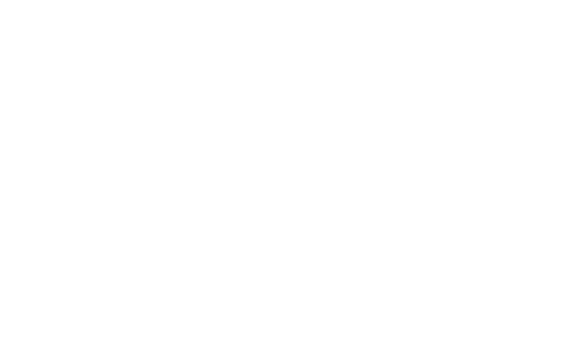

/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))


In [17]:
cpath = frad_paths[0]
ds = xr.open_dataset(cpath)
dsez = ds.Ez.sum(dim="Ionization", skipna=False)
max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()

QRB_index = 13
MW_fac = 1e-6
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
ds["tmp"] = dsez.isel(phi=QRB_index) # dsez.mean(dim="phi", skipna=False) # np.log10( 100+dsez )

fig, ax = plt.subplots(figsize=(6.3,4))  # figsize=(3,5)
cb = ax.pcolormesh(R, Z, MW_fac * ds["tmp"][:,:], 
                   cmap=cm.magma, norm=colors.LogNorm(vmin=1e-3, vmax=1e1)) # , vmax=2e6)
ax.set_aspect("equal")

for i,file in enumerate(Path("./data/").glob("island*")):
    x, y = np.load(file)
    if i == 0:
        ax.plot(x,y, c="lime", lw=1.5, ls="-.", label="islands")
    else: ax.plot(x,y, c="lime", lw=1.5, ls="-.")
    
ax.set_ylim((0.55, 1.05)); ax.set_xlim((5.2, 6))
#ax.set_ylim((0, 1)); ax.set_xlim((5.3, 6.3))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cbb = fig.colorbar(cb)
cbb.set_label("mean emissivity $E_{\mathrm{tot}}$ along field line [MW/m$^3$]", rotation=270, verticalalignment='baseline')
fig.tight_layout()

<IPython.core.display.Javascript object>


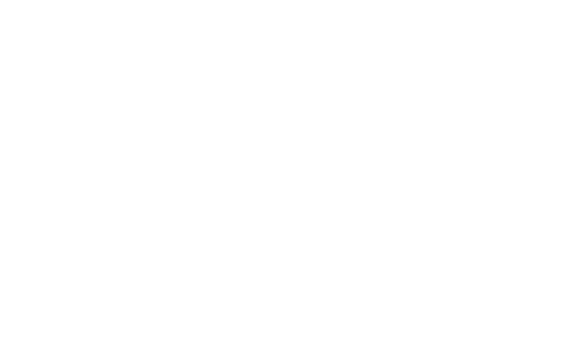

/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))


In [18]:
# ds["tmp"] = np.log10( 1+ dsez )
# # ds["tmp"] = np.log10(  1+ ds.Ez.isel(Ionization=1) )
# plt.close("all")
# ds.emc3.plot_rz("tmp", phi=0)
import matplotlib.colors as colors

cpath = frad_paths[-1]
ds = xr.open_dataset(cpath)
dsez = ds.Ez.sum(dim="Ionization", skipna=False)
max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()

QRB_index = 13
MW_fac = 1e-6
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
ds["tmp"] = dsez.mean(dim="phi", skipna=False) # np.log10( 100+dsez )

fig, ax = plt.subplots(figsize=(6.3,4))  # figsize=(3,5)
cb = ax.pcolormesh(R, Z, MW_fac * ds["tmp"][:,:], 
                   cmap=cm.magma, norm=colors.LogNorm(vmin=1e-3, vmax=1e1)) # , vmax=2e6)
ax.set_aspect("equal")

for i,file in enumerate(Path("./data/").glob("island*")):
    x, y = np.load(file)
    if i == 0:
        ax.plot(x,y, c="lime", lw=1.5, ls="-.", label="islands")
    else: ax.plot(x,y, c="lime", lw=1.5, ls="-.")
    
ax.plot(ds.R_bounds[max_ez_r,:,QRB_index,0,0,0],ds.z_bounds[max_ez_r,:,QRB_index ,0,0,0], c="cyan",
        ls=":", label="max. $E^z$")
ax.legend(loc=1)
    
ax.set_ylim((0.05, 1.05)); ax.set_xlim((4.9, 6.25))
#ax.set_ylim((0, 1)); ax.set_xlim((5.3, 6.3))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cbb = fig.colorbar(cb)
cbb.set_label("mean emissivity $E_{\mathrm{tot}}$ along field line [MW/m$^3$]", rotation=270, verticalalignment='baseline')
fig.tight_layout()

fig.savefig(f"{plotfolder}/emissivity-crossection-R02.50.pdf")
fig.savefig(f"{plotfolder}/emissivity-crossection-R02.50.png", dpi=200)

<IPython.core.display.Javascript object>


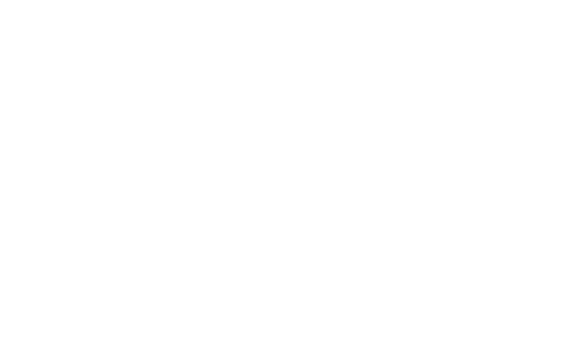

/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))


In [19]:
cpath = frad_paths[0]
ds = xr.open_dataset(cpath)
dsez = ds.Ez.sum(dim="Ionization", skipna=False)
max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()

QRB_index = 13
MW_fac = 1e-6
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
ds["tmp"] = dsez.mean(dim="phi", skipna=False) # np.log10( 100+dsez )

fig, ax = plt.subplots(figsize=(6.3,4))  # figsize=(3,5)
cb = ax.pcolormesh(R, Z, MW_fac * ds["tmp"][:,:], 
                   cmap=cm.magma, norm=colors.LogNorm(vmin=1e-3, vmax=1e1)) # , vmax=2e6)
ax.set_aspect("equal")

for i,file in enumerate(Path("./data/").glob("island*")):
    x, y = np.load(file)
    if i == 0:
        ax.plot(x,y, c="lime", lw=1.5, ls="-.", label="islands")
    else: ax.plot(x,y, c="lime", lw=1.5, ls="-.")
    
ax.plot(ds.R_bounds[max_ez_r,:,QRB_index,0,0,0],ds.z_bounds[max_ez_r,:,QRB_index ,0,0,0], c="cyan",
        ls=":", label="max. $E^z$")
ax.legend(loc=1)
    
ax.set_ylim((0.05, 1.05)); ax.set_xlim((4.9, 6.25))
#ax.set_ylim((0, 1)); ax.set_xlim((5.3, 6.3))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cbb = fig.colorbar(cb)
cbb.set_label("mean emissivity $E_{\mathrm{tot}}$ along field line [MW/m$^3$]", rotation=270, verticalalignment='baseline')
fig.tight_layout()

fig.savefig(f"{plotfolder}/emissivity-crossection-R04.50.pdf")
fig.savefig(f"{plotfolder}/emissivity-crossection-R04.50.png", dpi=200)

In [14]:
from importlib import reload
reload(cm)

<module 'matplotlib.cm' from '/u/phg/.local/lib/python3.7/site-packages/matplotlib/cm.py'>

<IPython.core.display.Javascript object>


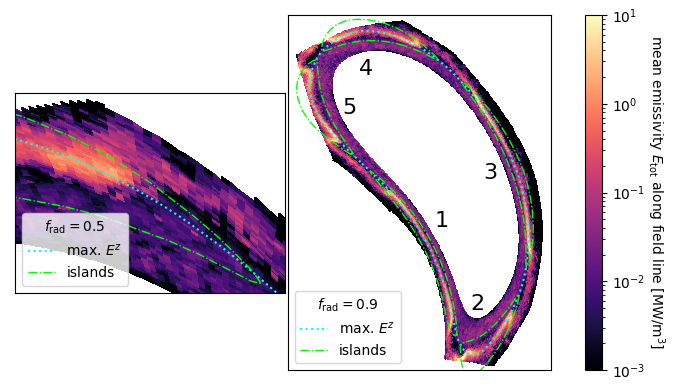

In [235]:
fig, axs = plt.subplots(figsize=(7,3.9), ncols=2)  # figsize=(3,5)
QRB_index = 13
MW_fac = 1e-6
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
philip_map = cm.magma
#philip_map.set_bad("k", alpha=0.1)

# qrb low
cpath = frad_paths[-1]
ds = xr.open_dataset(cpath)
dsez = ds.Ez.sum(dim="Ionization", skipna=False)
max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()
ds["tmp"] = dsez.mean(dim="phi", skipna=False) # np.log10( 100+dsez )
cb = axs[0].pcolormesh(R, Z, MW_fac * ds["tmp"][:,:], 
                   cmap=philip_map, norm=colors.LogNorm(vmin=1e-3, vmax=1e1)) # , vmax=2e6)
axs[0].set_aspect("equal")
axs[0].plot(ds.R_bounds[max_ez_r,:,QRB_index,0,0,0],ds.z_bounds[max_ez_r,:,QRB_index ,0,0,0], c="cyan",
        ls=":", label="max. $E^z$")

# qrb high
cpath = frad_paths[0]
ds = xr.open_dataset(cpath)
dsez = ds.Ez.sum(dim="Ionization", skipna=False)
max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()
ds["tmp"] = dsez.mean(dim="phi", skipna=False) # np.log10( 100+dsez )
cb = axs[1].pcolormesh(R, Z, MW_fac * ds["tmp"][:,:], 
                   cmap=philip_map, norm=colors.LogNorm(vmin=1e-3, vmax=1e1), zorder=2) # , vmax=2e6)
axs[1].set_aspect("equal")
axs[1].plot(ds.R_bounds[max_ez_r,:,QRB_index,0,0,0],ds.z_bounds[max_ez_r,:,QRB_index ,0,0,0], c="cyan",
        ls=":", label="max. $E^z$")

# islands
for i,file in enumerate(Path("./data/").glob("island*")):
    x, y = np.load(file)
    for axi in range(2):
        if i == 0:
            axs[axi].plot(x,y, c="lime", lw=1, ls="-.", label="islands")
            legtitle = "$f_{\mathrm{rad}} = 0.5$" if axi==0 else "$f_{\mathrm{rad}} = 0.9$"
            axs[axi].legend(loc=3, title=legtitle)
        else: axs[axi].plot(x,y, c="lime", lw=1, ls="-.")
    
for axi in range(2):   
    axs[axi].set_ylim((-0.77, 1.05)); axs[axi].set_xlim((4.9, 6.25))
    #ax.set_ylim((0, 1)); ax.set_xlim((5.3, 6.3))
    axs[axi].axes.xaxis.set_ticklabels([])
    axs[axi].axes.yaxis.set_ticklabels([])
    axs[axi].axes.xaxis.set_visible(False)
    axs[axi].axes.yaxis.set_visible(False)

# cbb = fig.colorbar(cb, ax=axs.ravel().tolist(), orientation='horizontal')
# cbb.set_label("mean emissivity $E^z$ along field line [MW/m$^3$]", rotation=0, verticalalignment='top')
fig.tight_layout()
cbb = fig.colorbar(cb, ax=axs.ravel().tolist())
cbb.set_label("mean emissivity $E_{\mathrm{tot}}$ along field line [MW/m$^3$]", rotation=270, verticalalignment='baseline')

thts = [55, 120, 250, 400, 460]
rs = [6, 12, 6, 8, 9]
for i in range(5):
    for axi in range(2):
        axs[axi].text(ds.R_bounds[rs[i],thts[i],13,0,0,0], ds.z_bounds[rs[i],thts[i],13,0,0,0], 
                    f"{i+1}", size=16, zorder=1e4, c="k", ha="center", va="center")

fig.savefig(f"{plotfolder}/emissivity-crossection-both.pdf")
fig.savefig(f"{plotfolder}/emissivity-crossection-both.png", dpi=200)

# Distance of R from seperatrix over frad

In [15]:
frads, delta_rs, peak_widths = [], [], []
for cpath in frad_paths:
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    ez_along_r = dsez.mean(dim=("theta", "phi"))
    max_ez_radius_index = (ez_along_r).argmax()
    max_ez_radius = ds.R_bounds[max_ez_radius_index,512//2,0].mean()
    separatrix_radius = 6.2072
    frads.append(float(cpath.stem[20:24])/float(cpath.stem[9:13]))
    delta_rs.append(max_ez_radius - separatrix_radius)
    peak_width = np.diff(ds.R_bounds[ez_along_r - ez_along_r[max_ez_radius_index]/2 > 0, 
                                     512//2, 0, :, 0, 0].data.flatten()).sum()
    peak_widths.append(peak_width)

<IPython.core.display.Javascript object>


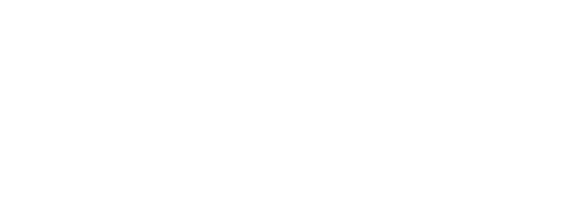

In [23]:
cm_fac=100
fig, ax = plt.subplots(figsize=(6.3,2.5))
ax2 = ax.twinx()
ax.errorbar(frads, cm_fac*np.array(delta_rs), fmt="P:", c="tab:blue", ms=8, lw=1)
ax2.errorbar(frads, cm_fac*np.array(peak_widths), fmt="P:", c="tab:red", ms=8, lw=1)
ax2.set_ylim((0,0.03*cm_fac))
ax.set_ylim((0,0.045*cm_fac))

ax.set_ylabel('$R_{E^z,\mathrm{max}} - R_{\mathrm{separatrix}}$ [cm]', color="tab:blue")
ax2.set_ylabel('$R_{E^z,\mathrm{max}}$ peak FWHM [cm]', color="tab:red", rotation=270, verticalalignment="baseline")

ax.set_xticks([0.5,0.6,0.7,0.8,0.9])
ax.set_yticks(cm_fac*np.array([0, 0.015, 0.030, 0.045]))
ax2.set_yticks(cm_fac*np.array([0, 0.01, 0.02, 0.03]))
ax.grid()
ax.set_xlabel("$f_{\mathrm{rad}}$")

fig.tight_layout()

fig.savefig(f"{plotfolder}/peak-radius-change-alternate.pdf")
fig.savefig(f"{plotfolder}/peak-radius-change-alternate.png", dpi=200)

# Take a look at target positions

In [16]:
targets = np.isnan(ds.Ez.isel(Ionization=0))
targets[:20]=0
targets = targets/(ds.r+1)

# (radial index, toroidal index) of closest target
int(targets.argmax(dim="r").min(dim="theta").min()), int(targets.argmax(dim="r").min(dim="theta").argmin())

(70, 15)

<IPython.core.display.Javascript object>


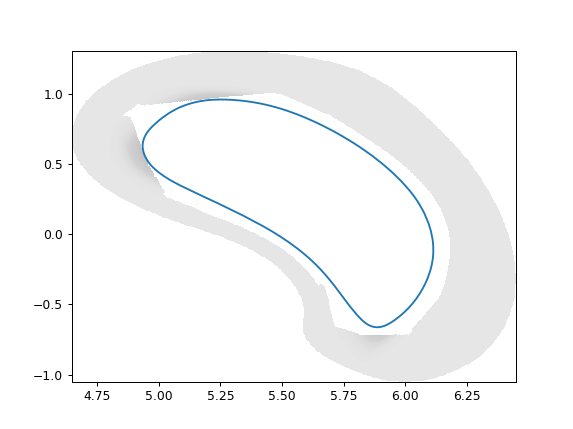

In [17]:
QRB_index = 15
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)

fig, ax = plt.subplots()
cb = ax.pcolormesh(R, Z, targets[:,:,QRB_index], cmap=cm.Greys, vmax=4e-2, vmin=0)
ax.plot(ds.R_bounds[70,:,QRB_index,0,0,0].data, ds.z_bounds[70,:,QRB_index,0,0,0].data)

# frad movement

In [18]:
# smoos array
def smoos(x):
    x = np.array(x)
    out = np.zeros_like(x)
    out[:-1] += x[1:]/4
    out[1:] += x[:-1]/4
    out += x/2
    out[-1] += x[0]/4
    out[0] += x[-1]/4
    return out

def nsmoos(x,n):
    for i in range(n):
        x = smoos(x)
    return x

In [20]:
cpath = frad_paths[0]
dsx = xr.open_dataset(cpath)
dsezx = dsx.Ez.sum(dim="Ionization", skipna=False)
dsx["tmp"] = 1+0*dsezx.mean(dim="phi", skipna=False) # np.log10( 100+dsez )
QRB_index = 13
MW_fac = 1e-6
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
fig, ax = plt.subplots(figsize=(4,3))  # figsize=(3,5)
cb = ax.pcolormesh(R, Z, dsx.tmp, cmap=cm.magma, zorder=3)
ax.set_aspect("equal")
ax.axvspan(0, 10, facecolor=(*(1.0,)*3,0.5), zorder=5) #, label="fraction of target cells")

rarr = []
dotarr = []
carr = []
labelarr = []
for cpath in frad_paths:
    ds = xr.open_dataset(cpath)
    dsmeanr = ds.R_bounds[:,:,QRB_index,:,:, 0].mean(dim=("delta_r", "delta_theta"))
    dsmeanz = ds.z_bounds[:,:,QRB_index,:,:, 0].mean(dim=("delta_r", "delta_theta"))
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()
    raw_ez = np.nan_to_num(dsez.isel(r=max_ez_r, phi=QRB_index))
    smoos_ez = nsmoos(raw_ez, 10)
    cut_ez = smoos_ez.copy()
    cut_ez[cut_ez < 2e5] = 0
    max_ez_tht = argrelextrema(cut_ez, np.greater, order=20)[0]
    print(max_ez_tht)
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    label="$f_{\mathrm{rad}} =$" + str(frad) + ", $D=$" + str(diffval)
    col=get_color(frad, diffval)
    
    dotarr.append(max_ez_tht)
    rarr.append(max_ez_r)
    carr.append(col)
    labelarr.append(label)
    
    ax.plot(ds.R_bounds[max_ez_r,:,QRB_index,0,0,0],ds.z_bounds[max_ez_r,:,QRB_index ,0,0,0], c="darkgrey",
        ls=":", zorder=80)

for line in np.array(dotarr).T:
    rs, zs = [], []
    for max_ez_r, pt in zip(rarr, line):
        rv = dsmeanr[max_ez_r.data[()], pt.data[()]].data[()]
        zv = dsmeanz[max_ez_r.data[()], pt.data[()]].data[()]
        rs.append(rv)
        zs.append(zv)
    ax.plot(rs, zs, zorder=100, c="white")
    
for max_ez_r, dot, col, label in zip(rarr, dotarr, carr, labelarr):
    for i, pt in enumerate(dot):
        rv = dsmeanr[max_ez_r.data[()], pt.data[()]].data[()]
        zv = dsmeanz[max_ez_r.data[()], pt.data[()]].data[()]
        if i==0:
            ax.scatter([rv], [zv], color=col, zorder=100, label=label, marker="X", s=30)
        else:
            ax.scatter([rv], [zv], color=col, zorder=100, marker="X", s=30)


for i,file in enumerate(Path("./data/").glob("island*")):
    x, y = np.load(file)
    if i == 0:
        ax.plot(x,y, c="lime", lw=1, ls="-", label="islands", zorder=6)
    else: ax.plot(x,y, c="lime", lw=1, ls="-", zorder=6)
    
for i,file in enumerate(Path("./data/").glob("INNER1*")):
    x, y = np.load(file)
    ax.plot(x,y, c="lime", lw=1, ls="-", zorder=6)


    
ax.set_xlim((4.9,5.7))
ax.set_ylim((0.39,1.05))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.legend(loc=4)
fig.tight_layout()

ax.text(5.18, 0.62, "4", ha="center", va="center", size=16, c="k", alpha=1, zorder=10000)
ax.text(5.37, 0.82, "5", ha="center", va="center", size=16, c="k", alpha=1, zorder=10000)
fig.savefig(f"{plotfolder}/frad-max-movement.pdf")
fig.savefig(f"{plotfolder}/frad-max-movement.png", dpi=200)

# the maximum we trac is the one in QRB!!!

<IPython.core.display.Javascript object>

[ 22  72 114 167 220 293 345 393 439 487]
[ 24  69 116 163 220 292 349 393 441 485]
[ 25  69 119 162 221 290 350 391 446 480]
[ 27  68 118 162 221 290 350 389 452 478]
[ 25  69 113 162 219 293 348 389 444 484]


# Temperature Plot

In [19]:
relevant_paths = [frad_paths[0], frad_paths[2], frad_paths[4], diff_paths[1], diff_paths[2]]
relevant_paths

[PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc')]

In [20]:
relevant_paths

[PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc')]

In [35]:
np.warnings.filterwarnings('ignore')  #to ignore warnings (usually due to NaN values)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(8,4))
gs = GridSpec(2, 5, figure=fig, height_ratios=[1, 0.05])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0, 4])
axx = fig.add_subplot(gs[1, :])
axs = (ax1, ax2, ax3, ax4, ax5)

QRB_index = 13
MW_fac = 1e-6
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
philip_map = cm.magma
#philip_map.set_bad("k", alpha=0.1)

for cpath, ax in zip(relevant_paths, axs[:]):
    print(cpath)
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()
    
    
    ds["tmp"] = ds.Te.isel(phi=QRB_index)
    #ds["tmp"] = ds.Te.mean(dim="phi", skipna=False) # np.log10( 100+dsez )
    #print(ds.tmp.max(), ds.tmp.min())
    
    
    cb = ax.pcolormesh(R, Z, ds["tmp"][:,:], 
                       cmap=philip_map, norm=colors.LogNorm(vmin=5e0, vmax=5e2)) # , vmax=2e6)
    ax.set_aspect("equal")
#     ax.plot(ds.R_bounds[max_ez_r,:,QRB_index,0,0,0],ds.z_bounds[max_ez_r,:,QRB_index ,0,0,0], c="cyan",
#             ls=":", label="max. $E^z$")
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    title = "$D = " + str(diffval) + "$ m$^2$/s\n" + "$f_{\mathrm{rad}} =$" + str(frad)
    ax.text(4.91, 1.09, title, va="top", ha="left", fontsize=10)
    
    dsez.isel(phi=QRB_index)
    mid_Z = (Z[1:,1:] + Z[:-1,1:] + Z[:-1,:-1] + Z[1:,:-1])/4
    mid_R = (R[1:,1:] + R[:-1,1:] + R[:-1,:-1] + R[1:,:-1])/4
    sigma = [1.5, 1.5]
    smooth_val = sp.ndimage.filters.gaussian_filter(np.nan_to_num(dsez.isel(phi=QRB_index)),
                                                    sigma, mode='constant')
    ax.contour(mid_R, mid_Z, smooth_val, levels=[0.4e6], colors="cyan")

# islands
for i,file in enumerate(Path("./data/").glob("island*")):
    x, y = np.load(file)
    for ax in axs:
        if i == 0:
            ax.plot(x,y, c="lime", lw=1, ls="-.", label="islands")
            legtitle = "$f_{\mathrm{rad}} = 0.5$" if i==0 else "$f_{\mathrm{rad}} = 0.9$"
            #axs[axi].legend(loc=3, title=legtitle)
        else: ax.plot(x,y, c="lime", lw=1, ls="-.")
            
for i,file in enumerate(Path("./data/").glob("INNER1*")):
    print(file)
    x, y = np.load(file)
    for ax in axs:
        if i == 0:
            ax.plot(x,y, c="lime", lw=1, ls="-.", label="islands")
            legtitle = "$f_{\mathrm{rad}} = 0.5$" if i==0 else "$f_{\mathrm{rad}} = 0.9$"
            #axs[axi].legend(loc=3, title=legtitle)
        else: ax.plot(x,y, c="lime", lw=1, ls="-.")
    
for ax in axs:   
    # axs[axi].set_ylim((-0.9, 1.05)); axs[axi].set_xlim((4.9, 6.25))
    #ax.set_ylim((0, 1)); ax.set_xlim((5.3, 6.3))
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim((4.9,5.2))
    ax.set_ylim((0.5,1.1))

# cbb = fig.colorbar(cb, ax=axs.ravel().tolist(), orientation='horizontal')
# cbb.set_label("mean emissivity $E^z$ along field line [MW/m$^3$]", rotation=0, verticalalignment='top')')

zs = [1.04, 0.57]
rs = [5.15, 4.94]
for i in range(2):
    for ax in axs:
        ax.text(rs[i], zs[i], 
                    f"{i+4}", size=16, zorder=1e4, c="k", ha="center", va="center")
        
cbb = fig.colorbar(cb,  cax=axx, orientation='horizontal', extend="both")
cbb.set_label("mean $T_e$ along field line [eV]", rotation=0, size=12)
fig.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0.15, left=0.02, right=0.98)

#fig.savefig(f"{plotfolder}/temperature-profiles.pdf")
fig.savefig(f"{plotfolder}/temperature-profiles.png", dpi=200)

<IPython.core.display.Javascript object>

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc
data/INNER1island3.npy
data/INNER1island2.npy
data/INNER1island1.npy
data/INNER1island4.npy


# just an overview Ez plot in qrb

<IPython.core.display.Javascript object>


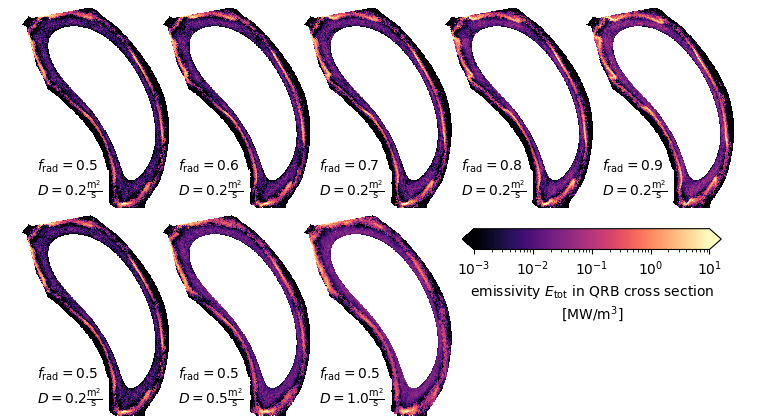

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc


In [203]:
fig = plt.figure(constrained_layout=True, figsize=(7.6,4.2))
gs = GridSpec(20, 30, figure=fig, height_ratios=20*[1])
axstop = [fig.add_subplot(gs[0:10, 6*i:6*i+6]) for i in range(5)]
axsbot = [fig.add_subplot(gs[10:20, 6*i:6*i+6]) for i in range(3)]
axscb = fig.add_subplot(gs[11:12, 19:29])
#axscb = fig.add_subplot(gs[11:19, 21])


QRB_index = 13
MW_fac = 1e-6
ds = xr.open_dataset(frad_paths[0])
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)

def pltcs(cpath, ax):
    print(cpath)
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    cb = ax.pcolormesh(R, Z, MW_fac*dsez.isel(phi=QRB_index), 
                       cmap=philip_map, norm=colors.LogNorm(vmin=MW_fac*1e3, vmax=MW_fac*1e7))
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    title = "$f_{\mathrm{rad}} =$" + str(frad) + "\n$D = " + str(diffval) + r"\frac{\mathrm{m}^2}{\mathrm{s}^{{\,}}}$"
    ax.text(5.03, -0.3, title, va="top", ha="left", fontsize=10)
    ax.set_ylim(-0.75, 1.1); ax.set_xlim(4.89, 6.25)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_aspect("equal")
    ax.axis('off')

for i, cpath in enumerate(frad_paths[::-1]):
    pltcs(cpath, axstop[i])
    
for i, cpath in enumerate(diff_paths[:]):
    pltcs(cpath, axsbot[i])

cbb = fig.colorbar(cb,  cax=axscb, extend="both", orientation="horizontal", fraction=0.1, shrink=0.1)
cbb.set_label("emissivity $E_{\mathrm{tot}}$ in QRB cross section\n[MW/m$^3$]", rotation=0, size=10, verticalalignment="top")
# cbb = fig.colorbar(cb,  cax=axscb, extend="both", fraction=0.1, shrink=0.1)
# cbb.set_label("mean $T_e$ along field line [eV]", rotation=270, size=10, verticalalignment="bottom")
fig.subplots_adjust(wspace=-0.5, hspace=0.00, top=1, bottom=0.01, left=0.02, right=0.98)

fig.savefig(f"{plotfolder}/all-QRB-ez.pdf")
fig.savefig(f"{plotfolder}/all-QRB-ez.png", dpi=200)

<IPython.core.display.Javascript object>


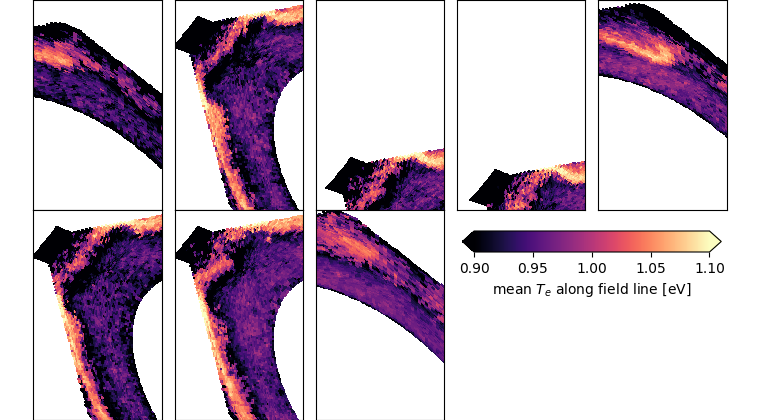

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc


In [259]:
fig = plt.figure(constrained_layout=True, figsize=(7.6,4.2))
gs = GridSpec(20, 30, figure=fig, height_ratios=20*[1])
axstop = [fig.add_subplot(gs[0:10, 6*i:6*i+6]) for i in range(5)]
axsbot = [fig.add_subplot(gs[10:20, 6*i:6*i+6]) for i in range(3)]
axscb = fig.add_subplot(gs[11:12, 19:29])
#axscb = fig.add_subplot(gs[11:19, 21])


QRB_index = 13
MW_fac = 1e-6
ds = xr.open_dataset(frad_paths[0])
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)

def pltcs(cpath, ax):
    print(cpath)
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    cb = ax.pcolormesh(R, Z, MW_fac*dsez.isel(phi=QRB_index), 
                       cmap=philip_map, norm=colors.LogNorm(vmin=MW_fac*1e3, vmax=MW_fac*1e7))
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    title = "$f_{\mathrm{rad}} =$" + str(frad) + "\n$D = " + str(diffval) + r"\frac{\mathrm{m}^2}{\mathrm{s}}$"
    ax.text(5.03, -0.3, title, va="top", ha="left", fontsize=10)
    ax.set_xlim((4.9,5.2)); ax.set_ylim((0.5,0.99))
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_aspect("equal")
    #ax.axis('off')

for i, cpath in enumerate(frad_paths[::-1]):
    pltcs(cpath, axstop[i])
    
for i, cpath in enumerate(diff_paths[:]):
    pltcs(cpath, axsbot[i])

cbb = fig.colorbar(cb,  cax=axscb, extend="both", orientation="horizontal", fraction=0.1, shrink=0.1)
cbb.set_label("mean $T_e$ along field line [eV]", rotation=0, size=10, verticalalignment="top")
# cbb = fig.colorbar(cb,  cax=axscb, extend="both", fraction=0.1, shrink=0.1)
# cbb.set_label("mean $T_e$ along field line [eV]", rotation=270, size=10, verticalalignment="bottom")
fig.subplots_adjust(wspace=-0.5, hspace=0.00, top=1, bottom=0, left=0.02, right=0.98)

# fig.savefig(f"{plotfolder}/all-QRB-ez-zoom.pdf")
# fig.savefig(f"{plotfolder}/all-QRB-ez-zoom.png", dpi=200)

<IPython.core.display.Javascript object>


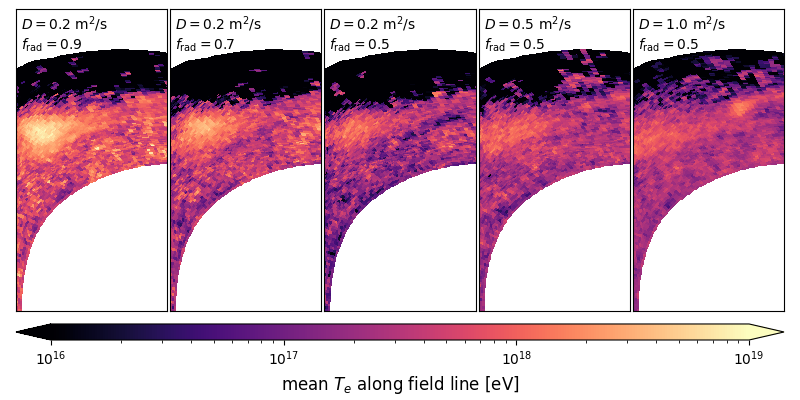

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc


In [247]:
np.warnings.filterwarnings('ignore')  #to ignore warnings (usually due to NaN values)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(8,4))
gs = GridSpec(2, 5, figure=fig, height_ratios=[1, 0.05])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0, 4])
axx = fig.add_subplot(gs[1, :])
axs = (ax1, ax2, ax3, ax4, ax5)

QRB_index = 20
MW_fac = 1e-6
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
philip_map = cm.magma
#philip_map.set_bad("k", alpha=0.1)

for cpath, ax in zip(relevant_paths[:], axs):
    print(cpath)
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()
    
    ds["tmp"] = ds.nZ1.isel(phi=QRB_index) + ds.nZ2.isel(phi=QRB_index) + ds.nZ3.isel(phi=QRB_index) + \
                ds.nZ4.isel(phi=QRB_index) + ds.nZ5.isel(phi=QRB_index) + ds.nZ6.isel(phi=QRB_index)
    # ds["tmp"] = ds.ne.isel(phi=QRB_index)
    #ds["tmp"] = ds.Te.mean(dim="phi", skipna=False) # np.log10( 100+dsez )
    #print(ds.tmp.max(), ds.tmp.min())
    
    
    cb = ax.pcolormesh(R, Z, ds["tmp"][:,:], 
                       cmap=philip_map, 
                       #norm=colors.LogNorm(vmin=1e18, vmax=1e20)) #ne
                        norm=colors.LogNorm(vmin=1e16, vmax=1e19)) #nz
    ax.set_aspect("equal")
#     ax.plot(ds.R_bounds[max_ez_r,:,QRB_index,0,0,0],ds.z_bounds[max_ez_r,:,QRB_index ,0,0,0], c="cyan",
#             ls=":", label="max. $E^z$")
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    title = "$D = " + str(diffval) + "$ m$^2$/s\n" + "$f_{\mathrm{rad}} =$" + str(frad)
    ax.text(4.91, 1.09, title, va="top", ha="left", fontsize=10)

for ax in axs:   
    # axs[axi].set_ylim((-0.9, 1.05)); axs[axi].set_xlim((4.9, 6.25))
    #ax.set_ylim((0, 1)); ax.set_xlim((5.3, 6.3))
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim((4.9,5.2))
    ax.set_ylim((0.5,1.1))

        
cbb = fig.colorbar(cb,  cax=axx, orientation='horizontal', extend="both")
cbb.set_label("mean $T_e$ along field line [eV]", rotation=0, size=12)
fig.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0.15, left=0.02, right=0.98)